<a href="https://colab.research.google.com/github/callen350/haadf-stem-hackathon/blob/master/notebooks/AtomicSemanticSegmention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic segmentation-based analysis of atomic images

Author: Maxim Ziatdinov

Email: ziatdinovmax@gmail.com



---


This notebook shows i) how to apply a UNet-like neural network for semantic segmentation of atomic images and to perform; ii) how to apply multivariate statistical analysis to the semantically-segmented output.


---



Install AtomAI:

In [1]:
!pip -q install git+https://github.com/pycroscopy/atomai # install the latest version from source
!pip -q install hyperspy

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.6 MB/s eta 0:00:00


Imports:

In [2]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
from google.colab import drive



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
### Load Necessary Libraries
from skimage.feature import peak_local_max as MaxPeak
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
from scipy import ndimage
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from scipy.optimize import curve_fit
from pylab import cm
import time
import copy
%matplotlib inline

In [5]:
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=width + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/sigma**2)
def bigauss(x,a1,a2,x01,x02,s1,s2):
    a=a1*np.exp(-(x-x01)**2/s1**2)
    b=a2*np.exp(-(x-x02)**2/s2**2)
    return a+b
def trigauss(x,a1,a2,a3,x01,x02,x03,s1,s2,s3):
    a=a1*np.exp(-(x-x01)**2/s1**2)
    b=a2*np.exp(-(x-x02)**2/s2**2)
    c=a3*np.exp(-(x-x03)**2/s3**2)
    return a+b+c
def tetragauss(x,a1,a2,a3,a4,x01,x02,x03,x04,s1,s2,s3,s4):
    a=a1*np.exp(-(x-x01)**2/s1**2)
    b=a2*np.exp(-(x-x02)**2/s2**2)
    c=a3*np.exp(-(x-x03)**2/s3**2)
    d=a4*np.exp(-(x-x04)**2/s4**2)
    return a+b+c+d
def pentagauss(x,a1,a2,a3,a4,a5,x01,x02,x03,x04,x05,s1,s2,s3,s4,s5):
    a=a1*np.exp(-(x-x01)**2/s1**2)
    b=a2*np.exp(-(x-x02)**2/s2**2)
    c=a3*np.exp(-(x-x03)**2/s3**2)
    d=a4*np.exp(-(x-x04)**2/s4**2)
    e=a5*np.exp(-(x-x05)**2/s5**2)
    return a+b+c+d+e

## Load multiple images for training and validation


PROCESSING FILE: 3D Stack align1.dm3
  -> Loading: 3D Stack align1.dm3
  -> Found 3340 total atoms
  -> Sorting Sites (A/B)...
  -> Classifying Species...


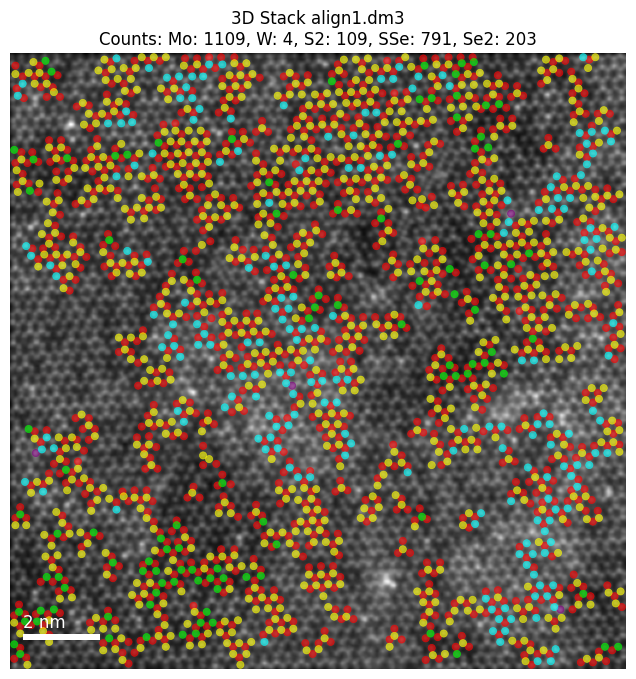


PROCESSING FILE: 3D Stack align2.dm3
  -> Loading: 3D Stack align2.dm3
  -> Found 5442 total atoms
  -> Sorting Sites (A/B)...
  -> Classifying Species...


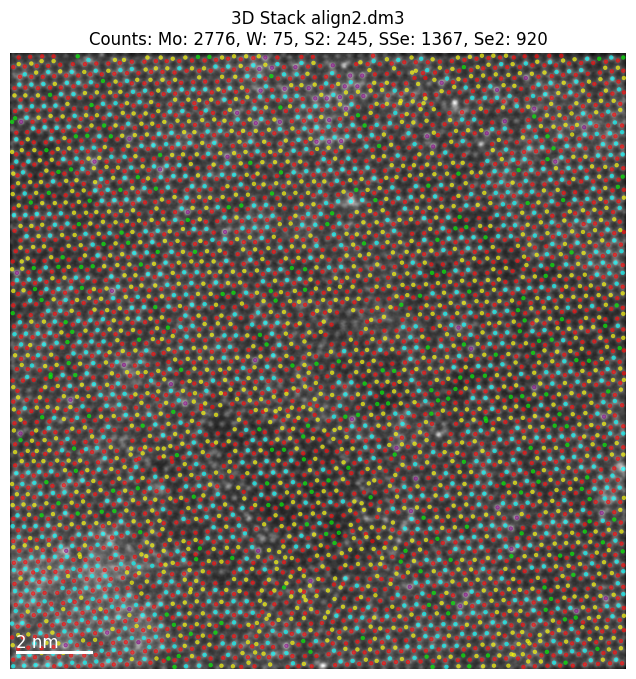


PROCESSING FILE: 3D Stack align3.dm3
  -> Loading: 3D Stack align3.dm3
  -> Found 5283 total atoms
  -> Sorting Sites (A/B)...
  -> Classifying Species...


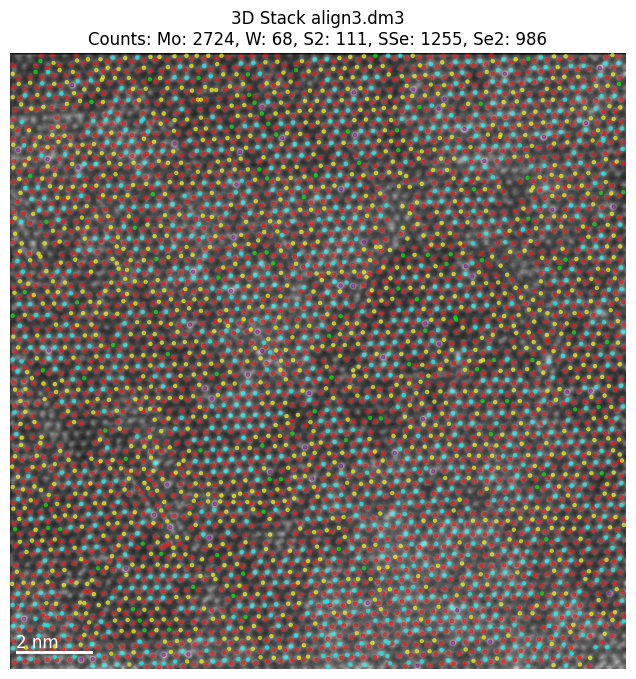


PROCESSING FILE: 3D Stack align4.dm3
  -> Loading: 3D Stack align4.dm3
  -> Found 1387 total atoms
  -> Sorting Sites (A/B)...
  -> Classifying Species...


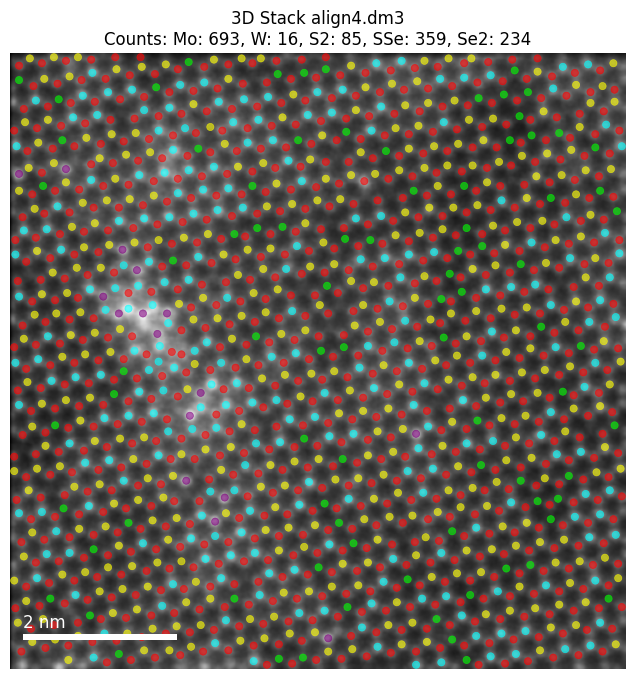


BATCH PROCESSING COMPLETE in 72.05 seconds
Created dataset with 4 entries.


In [ ]:
import os
from scipy.spatial import cKDTree


# --- CONFIGURATION ---
BASE_PATH = '/content/drive/MyDrive/hackathon/QuaternaryAlloyMoWSSe/aligned/'
FILENAMES = [
    '3D Stack align1.dm3',
    '3D Stack align2.dm3',
    '3D Stack align3.dm3',
    '3D Stack align4.dm3'
]

# Standardize thresholds (Assuming normalized 0-1 intensities)
# Note: Deep learning models often handle intensity variations better,
# but for generating Ground Truth, consistent normalization is key.
THRESHOLDS_A = [0.71]       # Mo < 0.71 < W
THRESHOLDS_B = [0.36, 0.555] # S2 < 0.36 < SSe < 0.555 < Se2

# --- HELPER FUNCTIONS ---

def load_and_preprocess(filepath):
    """Loads dm3, sums stack, smooths, and normalizes."""
    print(f"  -> Loading: {os.path.basename(filepath)}")
    s = hs.load(filepath)
    cal = s.axes_manager[2].scale

    # Sum Z-stack if it's 3D, else just take data
    if s.data.ndim == 3:
        img = np.sum(s.data, axis=0)
    else:
        img = s.data

    # Gaussian Smooth
    img = ndimage.gaussian_filter(img, 1.0)

    # Normalize 0 to 1
    norm_img = (img - np.amin(img)) / np.ptp(img)

    return norm_img, cal

def find_atoms(img, min_dist=3, threshold=0.1):
    """Identifies atomic columns using peak finding."""
    # Using skimage's peak_local_max as a robust standard replacement
    coordinates = MaxPeak(img, min_distance=min_dist, threshold_rel=threshold, exclude_border=True)
    # skimage returns [row, col], your code expects [y, x] which is [row, col]
    return coordinates

def sort_sites_fast(allatoms, cal, T=0.25):
    """
    Optimized O(N log N) sorting of A vs B sites using KD-Tree.
    Replaces the slow O(N^2) loops.
    """
    print("  -> Sorting Sites (A/B)...")
    tree = cKDTree(allatoms)

    # Query all neighbors within distance T
    # dividing T by cal converts physical distance (nm) to pixel distance
    indices = tree.query_ball_point(allatoms, r=T/cal)

    ASite = set()
    BSite = set()
    Others = set()

    # Step 1: Geometry Check (Triangular vs inverted triangular)
    for i, neighbors in enumerate(indices):
        real_neighbors = [n for n in neighbors if n != i]

        if len(real_neighbors) == 3:
            # Calculate vectors
            vecs = (allatoms[i] - allatoms[real_neighbors]) * cal
            # Check vertical alignment (Y-axis is index 0 in numpy image coords)
            # y > 0 means neighbor is "above" in the matrix
            pm = np.sum(vecs[:, 0] > 0) - np.sum(vecs[:, 0] <= 0)

            if pm > 0: ASite.add(i)
            else: BSite.add(i)
        else:
            Others.add(i)

    # Step 2: Iterative cleanup (Majority voting)
    # If an 'Other' atom is surrounded by B-sites, it must be an A-site
    changed = True
    iteration = 0
    while changed and iteration < 50:
        changed = False
        iteration += 1
        current_others = list(Others)

        for o in current_others:
            n_idxs = [n for n in indices[o] if n != o]
            n_A = sum(1 for n in n_idxs if n in ASite)
            n_B = sum(1 for n in n_idxs if n in BSite)

            if n_B > n_A:
                ASite.add(o); Others.remove(o); changed = True
            elif n_A > n_B:
                BSite.add(o); Others.remove(o); changed = True

    return list(ASite), list(BSite)

def classify_species(img, allatoms, ASite, BSite, t_A, t_B):
    """
    Classifies specific species based on intensity thresholds.
    Returns a dictionary of coordinates for each species.
    """
    print("  -> Classifying Species...")

    # Extract intensities
    A_coords = allatoms[ASite]
    B_coords = allatoms[BSite]

    A_int = img[A_coords[:,0], A_coords[:,1]]
    B_int = img[B_coords[:,0], B_coords[:,1]]

    labels = {} # Store results here

    # Classify A Sites (Mo vs W)
    # Logic: Intensity < Threshold = Mo, else W
    mask_Mo = A_int < t_A[0]
    labels['Mo'] = A_coords[mask_Mo]
    labels['W'] = A_coords[~mask_Mo]

    # Classify B Sites (S2 vs SSe vs Se2)
    # Logic: S2 < t1 < SSe < t2 < Se2
    mask_S2 = B_int < t_B[0]
    mask_Se2 = B_int > t_B[1]
    mask_SSe = ~(mask_S2 | mask_Se2) # Everything in between

    labels['S2'] = B_coords[mask_S2]
    labels['SSe'] = B_coords[mask_SSe]
    labels['Se2'] = B_coords[mask_Se2]

    return labels

def visualize_final(img, labels, filename, cal):
    """Plots the final classification map."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img, cmap='gray')

    # Define colors for classes
    color_map = {
        'Mo': 'red', 'W': 'purple',
        'S2': 'lime', 'SSe': 'yellow', 'Se2': 'cyan'
    }

    r = 3 # Radius for visual circles

    # Plot each species
    count_str = []
    for species, coords in labels.items():
        count_str.append(f"{species}: {len(coords)}")
        for (y, x) in coords:
            # Note: Matplotlib expects (x, y), numpy is (row, col) i.e. (y, x)
            ax.add_patch(Circle((x, y), radius=r, color=color_map[species], alpha=0.6, lw=0.5))

    # Scale bar (2 nm)
    # Width in pixels = 2 nm / scale
    sb_width = 2 / cal
    rect = Rectangle((10, img.shape[0]-30), sb_width, 5, fc='white')
    ax.add_patch(rect)
    ax.text(10, img.shape[0]-35, '2 nm', color='white', fontsize=12)

    plt.title(f"{filename}\nCounts: {', '.join(count_str)}")
    plt.axis('off')
    plt.show()

# --- MAIN EXECUTION LOOP ---

# Initialize dataset list to store training data
# Structure: [{'image': np_array, 'labels': {'Mo': [[y,x]...], ...}}, ...]
dataset = []

total_start = time.time()

for fname in FILENAMES:
    print(f"\nPROCESSING FILE: {fname}")
    full_path = os.path.join(BASE_PATH, fname)

    # 1. Load
    nIm, cal = load_and_preprocess(full_path)

    # 2. Find Atoms
    allatoms = find_atoms(nIm, min_dist=3, threshold=0.1)
    print(f"  -> Found {len(allatoms)} total atoms")

    # 3. Sort A/B Sites (Optimized)
    ASite_idxs, BSite_idxs = sort_sites_fast(allatoms, cal)

    # 4. Classify Species
    species_labels = classify_species(nIm, allatoms, ASite_idxs, BSite_idxs, THRESHOLDS_A, THRESHOLDS_B)

    # 5. Add to Dataset
    data_entry = {
        'filename': fname,
        'image': nIm,
        'scale': cal,
        'annotations': species_labels
    }
    dataset.append(data_entry)

    # 6. Visualize
    visualize_final(nIm, species_labels, fname, cal)

print("\n" + "="*40)
print(f"BATCH PROCESSING COMPLETE in {time.time()-total_start:.2f} seconds")
print(f"Created dataset with {len(dataset)} entries.")
print("="*40)

# Example: Accessing data for Deep Learning
# X_train = np.array([d['image'] for d in dataset])
# print("Training Data Shape:", X_train.shape)

In [ ]:
# Example: Accessing data for Deep Learning
for d in dataset:
    print(d['image'].shape)

print('2 of the images are 512x512 and 2 are 1024x1024')

(512, 512)
(1024, 1024)
(1024, 1024)
(512, 512)


In [ ]:
# Splits dataset into 512x512 images (by cutting 1024x1024 images into 4 sections)

import numpy as np
import copy

def split_image_and_labels(entry, crop_size=512):
    """
    Splits a 1024x1024 entry into four 512x512 entries,
    adjusting atom coordinates automatically.
    """
    img = entry['image']
    h, w = img.shape

    # If already the right size, return as a single-item list
    if h == crop_size and w == crop_size:
        return [entry]

    # Define the 4 quadrants (y_start, x_start)
    # Top-Left, Top-Right, Bottom-Left, Bottom-Right
    offsets = [
        (0, 0),
        (0, crop_size),
        (crop_size, 0),
        (crop_size, crop_size)
    ]

    new_entries = []

    for i, (oy, ox) in enumerate(offsets):
        # 1. Crop the Image
        # Slice: from oy to oy+512, from ox to ox+512
        crop_img = img[oy : oy+crop_size, ox : ox+crop_size]

        # 2. Adjust Annotations
        new_annotations = {}

        for species, coords in entry['annotations'].items():
            if len(coords) == 0:
                new_annotations[species] = np.array([])
                continue

            # Convert to numpy for easy math
            coords = np.array(coords)

            # Shift coordinates: New = Old - Offset
            # coords is [y, x], so we subtract [oy, ox]
            shifted_coords = coords - np.array([oy, ox])

            # Filter: Keep atoms that are actually inside this crop
            # (0 <= y < 512) AND (0 <= x < 512)
            mask = (
                (shifted_coords[:, 0] >= 0) &
                (shifted_coords[:, 0] < crop_size) &
                (shifted_coords[:, 1] >= 0) &
                (shifted_coords[:, 1] < crop_size)
            )

            new_annotations[species] = shifted_coords[mask]

        # 3. Create new dataset entry
        new_entry = {
            'filename': f"{entry['filename']}_crop_{i+1}",
            'image': crop_img,
            'scale': entry['scale'],
            'annotations': new_annotations
        }
        new_entries.append(new_entry)

    return new_entries

# --- EXECUTION ---

final_dataset = []

print(f"Original Dataset Size: {len(dataset)}")

for data_entry in dataset:
    # Run the split function on each existing entry
    splits = split_image_and_labels(data_entry, crop_size=512)
    final_dataset.extend(splits)

print(f"New Dataset Size: {len(final_dataset)}")

# --- VERIFICATION ---
# Let's check the shapes to be sure
shapes = [d['image'].shape for d in final_dataset]
print(f"Unique image shapes in final dataset: {set(shapes)}")
# Should print: {(512, 512)}

Original Dataset Size: 4
New Dataset Size: 10
Unique image shapes in final dataset: {(512, 512)}


In [ ]:
# Example: Accessing data for Deep Learning
X_train = np.array([d['image'] for d in final_dataset])
print("Training Data Shape:", X_train.shape)

Training Data Shape: (10, 512, 512)


In [ ]:
## Save dataset as pickle file

import pickle
import os

output_path = '/content/drive/MyDrive/hackathon/QuaternaryAlloyMoWSSe/final_dataset.pkl'

# Ensure the directory exists (MyDrive is usually always there)
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)

with open(output_path, 'wb') as f:
    pickle.dump(final_dataset, f)

print(f"final_dataset successfully saved to {output_path}")

final_dataset successfully saved to /content/drive/MyDrive/hackathon/QuaternaryAlloyMoWSSe/final_dataset.pkl


In [6]:
## Load dataset from pickle file

import pickle
import os

input_path = '/content/drive/MyDrive/hackathon/QuaternaryAlloyMoWSSe/final_dataset.pkl'

# Ensure the file exists
if not os.path.exists(input_path):
    print(f"Error: File not found at {input_path}")
else:
    with open(input_path, 'rb') as f:
        final_dataset = pickle.load(f)

### Run the below cell for model training & validation

Generating Segmentation Masks...
Input Shape: (10, 1, 512, 512)
Mask Shape: (10, 512, 512)
Starting Training...
Epoch 1/300 ... Training loss: 2.0877 ... Test loss: 1.8667 ... Train Accuracy: 0.0708 ... Test Accuracy: 0.0768 ... GPU memory usage: 2102/15360
Epoch 100/300 ... Training loss: 0.4746 ... Test loss: 0.471 ... Train Accuracy: 0.6495 ... Test Accuracy: 0.6264 ... GPU memory usage: 2102/15360
Epoch 200/300 ... Training loss: 0.7688 ... Test loss: 0.4548 ... Train Accuracy: 0.5659 ... Test Accuracy: 0.7224 ... GPU memory usage: 2102/15360
Epoch 300/300 ... Training loss: 0.104 ... Test loss: 0.3338 ... Train Accuracy: 0.9173 ... Test Accuracy: 0.7507 ... GPU memory usage: 2102/15360
Model (final state) evaluation loss: 0.3338
Model (final state) accuracy: 0.7507
Performing stochastic weight averaging...
Model (final state) evaluation loss: 0.3219
Model (final state) accuracy: 0.746
Plotting training history


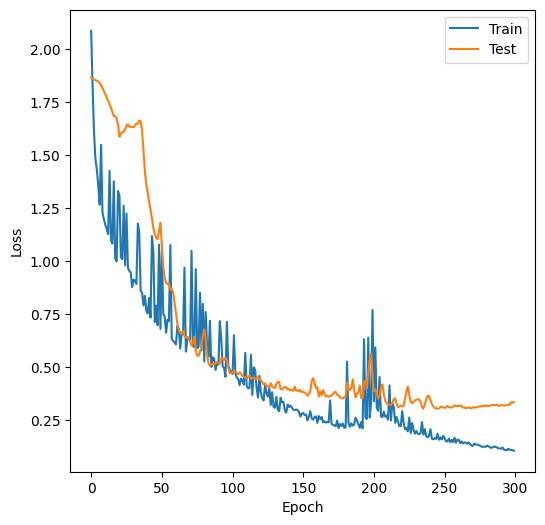

Predicting on Test Data...
Batch 2/2
2 images were decoded in approximately 0.1932 seconds


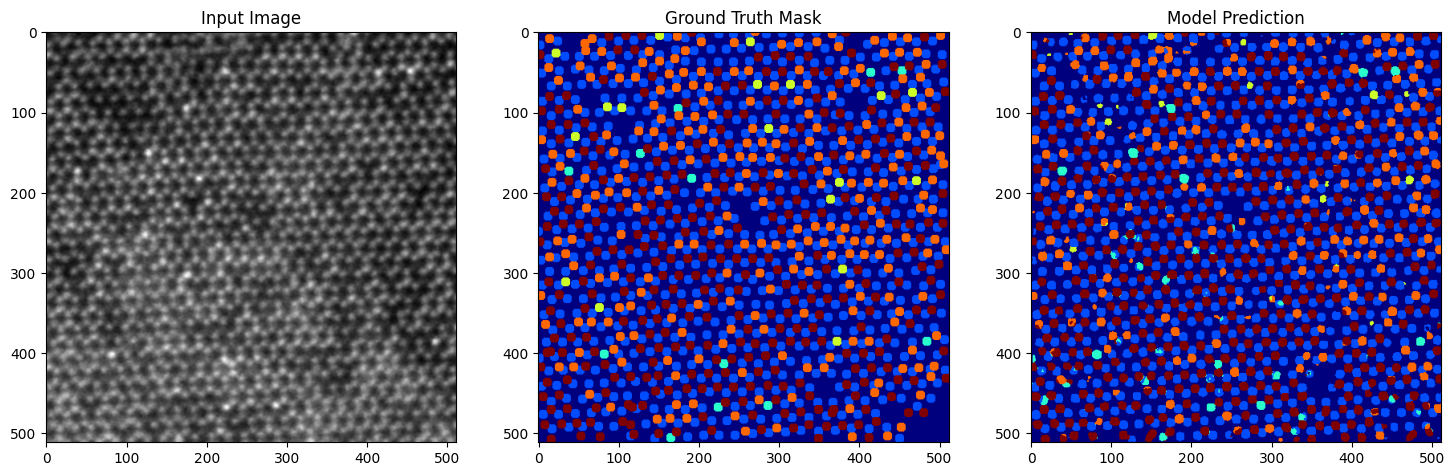

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk
from sklearn.model_selection import train_test_split
import atomai as aoi

# --- 1. DEFINE CLASS MAPPING ---
# 0 is always Background in semantic segmentation
class_map = {
    'Mo': 1,
    'W': 2,
    'S2': 3,
    'SSe': 4,
    'Se2': 5
}
nb_classes = len(class_map) + 1  # 5 atoms + 1 background = 6 classes

# --- 2. DATA TRANSFORMATION FUNCTION (Corrected for PyTorch Targets) ---
def create_segmentation_masks(dataset, height, width, radius=5):
    n_samples = len(dataset)

    # X (Images): 4D Shape (N, 1, H, W) <--- KEEPS CHANNEL DIM
    X = np.zeros((n_samples, 1, height, width))

    # Y (Labels): 3D Shape (N, H, W)    <--- REMOVES CHANNEL DIM
    Y = np.zeros((n_samples, height, width))

    for i, entry in enumerate(dataset):
        # Fill Image Array
        X[i, 0, :, :] = entry['image']

        # Fill Mask Array
        mask = np.zeros((height, width))
        for species, coords in entry['annotations'].items():
            class_idx = class_map[species]

            for coord in coords:
                rr, cc = disk((coord[0], coord[1]), radius, shape=(height, width))
                mask[rr, cc] = class_idx

        # Assign directly to the 3D array (no '0' index for channel)
        Y[i, :, :] = mask

    return X, Y

# --- 3. PREPARE DATA ---
print("Generating Segmentation Masks...")
X_all, Y_all = create_segmentation_masks(final_dataset, 512, 512, radius=6)

print(f"Input Shape: {X_all.shape}") # Should be (10, 1, 512, 512)
print(f"Mask Shape: {Y_all.shape}")  # Should be (10, 512, 512) <-- No '1'

# Split into Train and Test
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

# --- 4. TRAIN THE MODEL ---
# We use 6 classes (0=Background, 1-5=Atoms)
model = aoi.models.Segmentor(nb_classes=nb_classes)

print("Starting Training...")
model.fit(
    X_train, Y_train,
    X_test, Y_test,
    training_cycles=300,
    batch_size=2,        # Small batch size since we only have 8 training images
    compute_accuracy=True,
    swa=True             # Stochastic Weight Averaging for better generalization
)

# --- 5. VALIDATE & VISUALIZE ---
print("Predicting on Test Data...")
# Predict returns:
# nn_output: The probability map (N, H, W, Classes)
# coordinates: The extracted atomic coordinates from the map
nn_output, coordinates = model.predict(X_test)

# Visualize the first test image result
idx = 0
input_img = X_test[idx].squeeze()
true_mask = Y_test[idx].squeeze()
pred_mask = np.argmax(nn_output[idx], axis=-1) # Convert prob map to integer mask

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(input_img, cmap='gray')
ax1.set_title("Input Image")

ax2.imshow(true_mask, cmap='jet', vmin=0, vmax=5)
ax2.set_title("Ground Truth Mask")

ax3.imshow(pred_mask, cmap='jet', vmin=0, vmax=5)
ax3.set_title("Model Prediction")

plt.show()

### Run the below cell for validation only

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk
from sklearn.model_selection import train_test_split
import atomai as aoi

# --- 1. DEFINE CLASS MAPPING ---
# 0 is always Background in semantic segmentation
class_map = {
    'Mo': 1,
    'W': 2,
    'S2': 3,
    'SSe': 4,
    'Se2': 5
}
nb_classes = len(class_map) + 1  # 5 atoms + 1 background = 6 classes

# --- 2. DATA TRANSFORMATION FUNCTION (Corrected for PyTorch Targets) ---
def create_segmentation_masks(dataset, height, width, radius=5):
    n_samples = len(dataset)

    # X (Images): 4D Shape (N, 1, H, W) <--- KEEPS CHANNEL DIM
    X = np.zeros((n_samples, 1, height, width))

    # Y (Labels): 3D Shape (N, H, W)    <--- REMOVES CHANNEL DIM
    Y = np.zeros((n_samples, height, width))

    for i, entry in enumerate(dataset):
        # Fill Image Array
        X[i, 0, :, :] = entry['image']

        # Fill Mask Array
        mask = np.zeros((height, width))
        for species, coords in entry['annotations'].items():
            class_idx = class_map[species]

            for coord in coords:
                rr, cc = disk((coord[0], coord[1]), radius, shape=(height, width))
                mask[rr, cc] = class_idx

        # Assign directly to the 3D array (no '0' index for channel)
        Y[i, :, :] = mask

    return X, Y

# --- 3. PREPARE DATA ---
print("Generating Segmentation Masks...")
X_all, Y_all = create_segmentation_masks(final_dataset, 512, 512, radius=6)

print(f"Input Shape: {X_all.shape}") # Should be (10, 1, 512, 512)
print(f"Mask Shape: {Y_all.shape}")  # Should be (10, 512, 512) <-- No '1'

# Split into Train and Test
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)


# --- 4. LOAD MODEL ---
model = aoi.load_model('/content/drive/MyDrive/hackathon/QuaternaryAlloyMoWSSe/haadf_model_01.tar')

Generating Segmentation Masks...
Input Shape: (10, 1, 512, 512)
Mask Shape: (10, 512, 512)


Predicting on Test Data...
Batch 2/2
2 images were decoded in approximately 2.2305 seconds


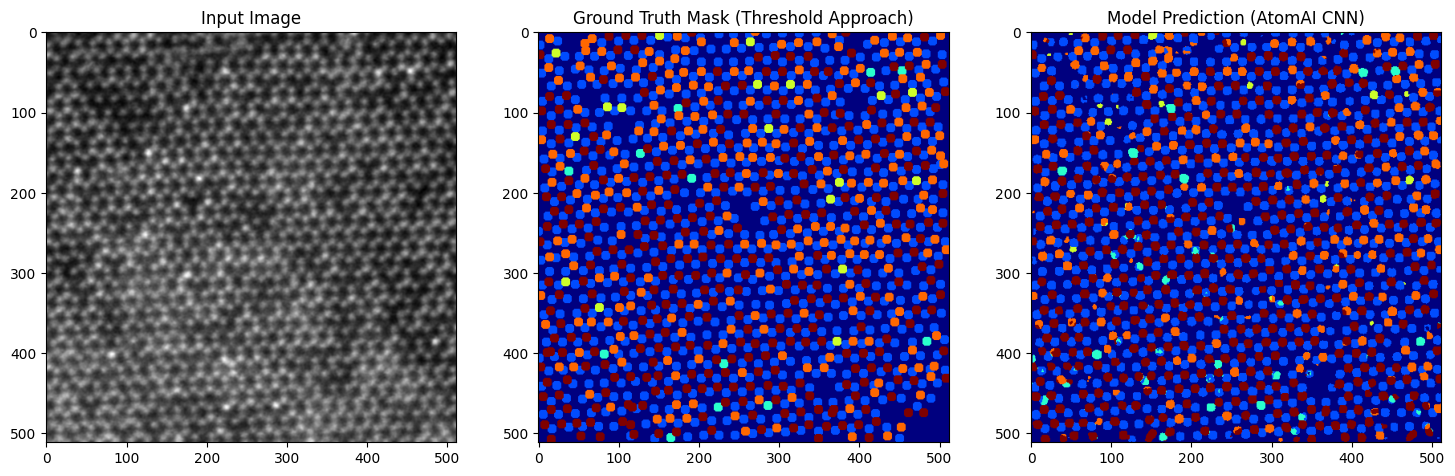

In [8]:
# --- 5. VALIDATE & VISUALIZE ---
print("Predicting on Test Data...")
# Predict returns:
# nn_output: The probability map (N, H, W, Classes)
# coordinates: The extracted atomic coordinates from the map
nn_output, coordinates = model.predict(X_test)

# Visualize the first test image result
idx = 0
input_img = X_test[idx].squeeze()
true_mask = Y_test[idx].squeeze()
pred_mask = np.argmax(nn_output[idx], axis=-1) # Convert prob map to integer mask

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(input_img, cmap='gray')
ax1.set_title("Input Image")

ax2.imshow(true_mask, cmap='jet', vmin=0, vmax=5)
ax2.set_title("Ground Truth Mask (Threshold Approach)")

ax3.imshow(pred_mask, cmap='jet', vmin=0, vmax=5)
ax3.set_title("Model Prediction (AtomAI CNN)")

plt.show()

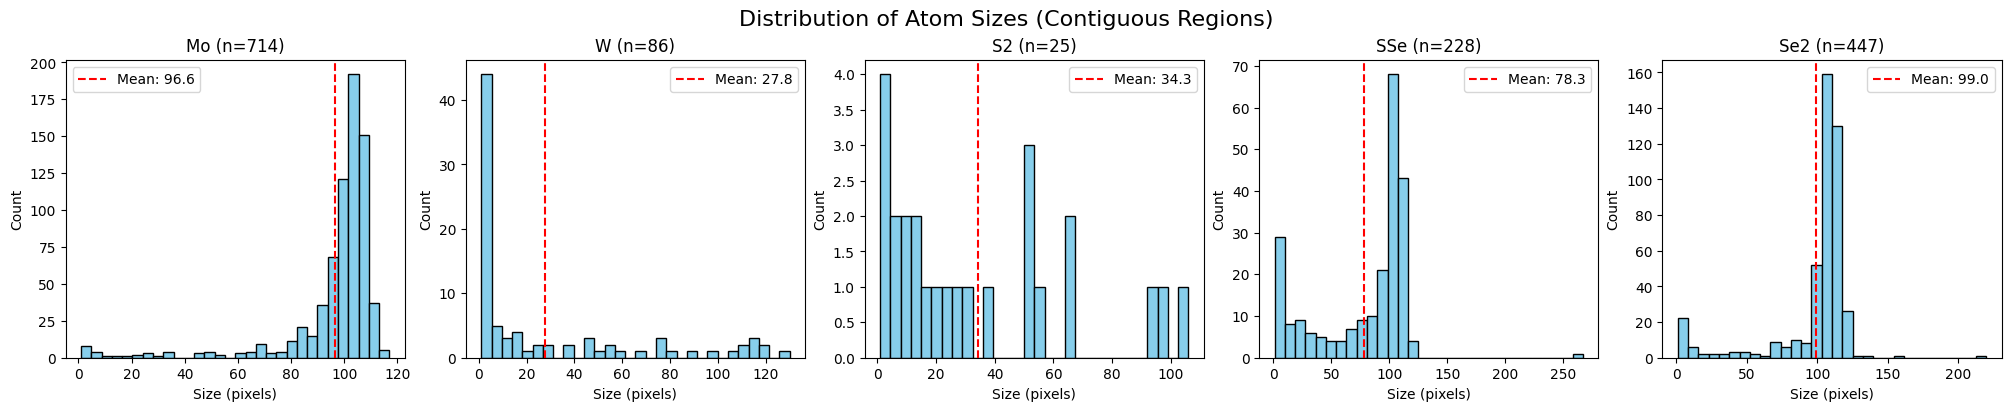

In [9]:
# Get blob areas

import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

def plot_class_size_histograms(mask, class_names=None):
    """
    Plots histograms of contiguous region sizes for each class in the mask.
    """
    if class_names is None:
        # Map 1-5 to names
        class_names = ['Mo', 'W', 'S2', 'SSe', 'Se2']

    # Create subplots (one for each class)
    n_classes = len(class_names)
    fig, axes = plt.subplots(1, n_classes, figsize=(20, 4), constrained_layout=True)

    # Loop through classes 1 to 5
    for i, ax in enumerate(axes):
        class_id = i + 1
        name = class_names[i]

        # 1. Create Binary Mask for this specific class
        binary_mask = (mask == class_id)

        # 2. Label connected components
        # connectivity=2 allows diagonal connections (8-neighbor)
        labeled_img = label(binary_mask, connectivity=2)

        # 3. Calculate properties (Area)
        regions = regionprops(labeled_img)
        sizes = [r.area for r in regions]

        # 4. Plot Histogram
        if len(sizes) > 0:
            ax.hist(sizes, bins=30, color='skyblue', edgecolor='black')
            ax.set_title(f"{name} (n={len(sizes)})")
            ax.set_xlabel("Size (pixels)")
            ax.set_ylabel("Count")

            # Optional: Add mean size line
            mean_size = np.mean(sizes)
            ax.axvline(mean_size, color='r', linestyle='--', label=f'Mean: {mean_size:.1f}')
            ax.legend()
        else:
            ax.text(0.5, 0.5, "No regions found", ha='center', transform=ax.transAxes)
            ax.set_title(f"{name}")

    plt.suptitle("Distribution of Atom Sizes (Contiguous Regions)", fontsize=16)
    plt.show()

# --- EXECUTION ---
# Assuming 'pred_mask' is your 512x512 array
plot_class_size_histograms(pred_mask)


Processing 2 images with Hungarian Matching...

  ATOM-WISE MATCHING SUMMARY
Total Ground Truth Atoms: 2666
Total Predicted Atoms:    2726
Successfully Matched:     2563
Match Rate (Recall):      96.14%
------------------------------


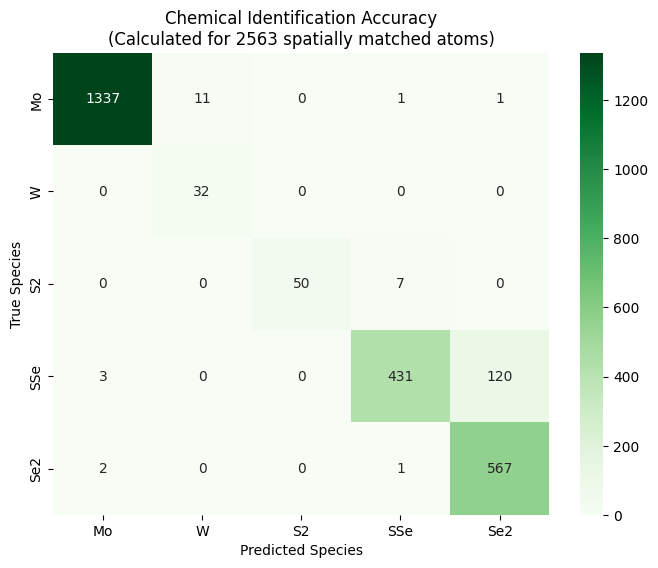


--- CLASSIFICATION REPORT (Matched Atoms Only) ---
              precision    recall  f1-score   support

          Mo       1.00      0.99      0.99      1350
           W       0.74      1.00      0.85        32
          S2       1.00      0.88      0.93        57
         SSe       0.98      0.78      0.87       554
         Se2       0.82      0.99      0.90       570

    accuracy                           0.94      2563
   macro avg       0.91      0.93      0.91      2563
weighted avg       0.95      0.94      0.94      2563


  DETECTION ERRORS (Misses & FPs)
Class      | Misses (FN)  | False Pos (FP)
----------------------------------------
Mo         | 43           | 57          
W          | 2            | 5           
S2         | 21           | 17          
SSe        | 32           | 62          
Se2        | 5            | 22          


In [10]:
## Atom-wise performance evaluation (looks for blobs (atoms) within 3 px of each other that are >30 px in size)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.measure import label, regionprops
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, classification_report

# --- CONFIGURATION ---
MIN_BLOB_SIZE = 30  # Pixels
MATCH_DIST_THRESHOLD = 3  # Pixels
CLASS_NAMES = ['Mo', 'W', 'S2', 'SSe', 'Se2']
# Mapping for reports (1-5 for atoms, 0 for Background/Miss/FP)
LABELS = [1, 2, 3, 4, 5]

def get_blob_centroids(mask, min_size=30):
    """
    Extracts (y, x, class_id) for every blob larger than min_size.
    """
    centroids = []
    # Iterate classes 1-5
    for class_id in [1, 2, 3, 4, 5]:
        # Create binary mask for this class
        binary = (mask == class_id)
        # Label blobs
        labeled = label(binary)
        regions = regionprops(labeled)

        for r in regions:
            if r.area >= min_size:
                # r.centroid is (row, col)
                centroids.append([r.centroid[0], r.centroid[1], class_id])

    return np.array(centroids)

def match_atoms_hungarian(gt_coords, pred_coords, tolerance=3.0):
    """
    Matches GT and Pred atoms using the Hungarian Algorithm (1-to-1 matching).
    Returns:
        matches: List of [gt_class, pred_class] for successful matches
        misses: List of [gt_class] that were not found
        false_positives: List of [pred_class] that didn't match any GT
    """
    # Handle empty cases
    if len(gt_coords) == 0:
        return [], [], list(pred_coords[:, 2])
    if len(pred_coords) == 0:
        return [], list(gt_coords[:, 2]), []

    # 1. Calculate Distance Matrix (Rows=GT, Cols=Pred)
    gt_spatial = gt_coords[:, :2]
    pred_spatial = pred_coords[:, :2]
    dist_matrix = cdist(gt_spatial, pred_spatial)

    # 2. Hungarian Algorithm to find optimal assignments
    # row_ind are GT indices, col_ind are Pred indices
    row_ind, col_ind = linear_sum_assignment(dist_matrix)

    matches = []
    matched_gt_indices = set()
    matched_pred_indices = set()

    # 3. Filter assignments by distance tolerance
    for r, c in zip(row_ind, col_ind):
        if dist_matrix[r, c] <= tolerance:
            gt_cls = gt_coords[r, 2]
            pred_cls = pred_coords[c, 2]
            matches.append([gt_cls, pred_cls])
            matched_gt_indices.add(r)
            matched_pred_indices.add(c)

    # 4. Identify Misses and False Positives
    all_gt_indices = set(range(len(gt_coords)))
    all_pred_indices = set(range(len(pred_coords)))

    miss_indices = all_gt_indices - matched_gt_indices
    fp_indices = all_pred_indices - matched_pred_indices

    misses = [gt_coords[i, 2] for i in miss_indices]
    false_positives = [pred_coords[i, 2] for i in fp_indices]

    return matches, misses, false_positives

# --- MAIN EXECUTION ---
print(f"Processing {len(Y_test)} images with Hungarian Matching...")

y_true_matched = []  # For Confusion Matrix (Chemical ID accuracy)
y_pred_matched = []

# Statistics counters
total_gt_atoms = 0
total_pred_atoms = 0
total_matches = 0
miss_counts = {c: 0 for c in CLASS_NAMES}
fp_counts = {c: 0 for c in CLASS_NAMES}

for i in range(len(Y_test)):
    # 1. Get Centroids
    gt_mask = Y_test[i].squeeze()
    pred_mask = np.argmax(nn_output[i], axis=-1)

    gt_blobs = get_blob_centroids(gt_mask, min_size=MIN_BLOB_SIZE)
    pred_blobs = get_blob_centroids(pred_mask, min_size=MIN_BLOB_SIZE)

    total_gt_atoms += len(gt_blobs)
    total_pred_atoms += len(pred_blobs)

    # 2. Match
    matches, misses, fps = match_atoms_hungarian(gt_blobs, pred_blobs, tolerance=MATCH_DIST_THRESHOLD)

    # 3. Collect Data
    for gt_cls, pred_cls in matches:
        y_true_matched.append(gt_cls)
        y_pred_matched.append(pred_cls)
        total_matches += 1

    for m in misses:
        class_name = CLASS_NAMES[int(m)-1]
        miss_counts[class_name] += 1

    for fp in fps:
        class_name = CLASS_NAMES[int(fp)-1]
        fp_counts[class_name] += 1

# --- REPORTING ---

print("\n" + "="*30)
print("  ATOM-WISE MATCHING SUMMARY")
print("="*30)
print(f"Total Ground Truth Atoms: {total_gt_atoms}")
print(f"Total Predicted Atoms:    {total_pred_atoms}")
print(f"Successfully Matched:     {total_matches}")
print(f"Match Rate (Recall):      {total_matches/total_gt_atoms:.2%}")
print("-" * 30)

# 1. CONFUSION MATRIX (Classification Accuracy of Matched Atoms)
if len(y_true_matched) > 0:
    cm = confusion_matrix(y_true_matched, y_pred_matched, labels=LABELS, normalize=None)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'Chemical Identification Accuracy\n(Calculated for {total_matches} spatially matched atoms)')
    plt.ylabel('True Species')
    plt.xlabel('Predicted Species')
    plt.show()

    print("\n--- CLASSIFICATION REPORT (Matched Atoms Only) ---")
    print(classification_report(y_true_matched, y_pred_matched, labels=LABELS, target_names=CLASS_NAMES))

# 2. DETECTION ERROR SUMMARY
print("\n" + "="*30)
print("  DETECTION ERRORS (Misses & FPs)")
print("="*30)
print(f"{'Class':<10} | {'Misses (FN)':<12} | {'False Pos (FP)':<12}")
print("-" * 40)
for name in CLASS_NAMES:
    print(f"{name:<10} | {miss_counts[name]:<12} | {fp_counts[name]:<12}")

--- PIXEL-WISE PERFORMANCE (Segmentation Mask) ---
IoU for Background: 0.8535
IoU for Mo: 0.8575
IoU for W: 0.6343
IoU for S2: 0.4289
IoU for SSe: 0.6354
IoU for Se2: 0.7267
Mean IoU: 0.6894

Classification Report:

              precision    recall  f1-score   support

  Background       0.91      0.93      0.92    241665
          Mo       0.93      0.91      0.92    143798
           W       0.68      0.91      0.78      3506
          S2       0.74      0.50      0.60      8564
         SSe       0.88      0.70      0.78     64075
         Se2       0.77      0.93      0.84     62680

    accuracy                           0.89    524288
   macro avg       0.82      0.81      0.81    524288
weighted avg       0.89      0.89      0.89    524288



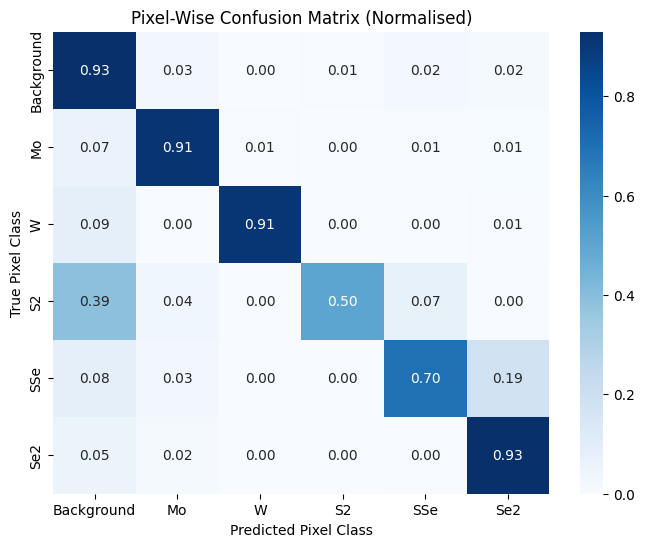

In [ ]:
## Pixel-wise performance evaluation

import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score

# --- 1. SETUP & FLATTEN DATA ---
# We flatten the arrays to 1D lists of pixels to compare them directly
# shape: (N_pixels, )
y_true_flat = Y_test.flatten().astype(int)
# Convert probability map to class integer mask (argmax)
y_pred_mask = np.argmax(nn_output, axis=-1)
y_pred_flat = y_pred_mask.flatten().astype(int)

# Define labels for the confusion matrix
class_names = ['Background', 'Mo', 'W', 'S2', 'SSe', 'Se2']

# --- 2. CALCULATE PIXEL METRICS ---
print("--- PIXEL-WISE PERFORMANCE (Segmentation Mask) ---")

# IoU (Intersection over Union) - The gold standard for segmentation
iou = jaccard_score(y_true_flat, y_pred_flat, average=None)
for i, name in enumerate(class_names):
    print(f"IoU for {name}: {iou[i]:.4f}")
print(f"Mean IoU: {np.mean(iou):.4f}")

# Full Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true_flat, y_pred_flat, target_names=class_names))

# --- 3. VISUALIZE PIXEL CONFUSION MATRIX ---
cm_pixel = confusion_matrix(y_true_flat, y_pred_flat, normalize='true') # Normalize by true rows

plt.figure(figsize=(8, 6))
sns.heatmap(cm_pixel, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Pixel-Wise Confusion Matrix (Normalised)')
plt.ylabel('True Pixel Class')
plt.xlabel('Predicted Pixel Class')
plt.show()

In [ ]:
model.save_model('/content/drive/MyDrive/hackathon/QuaternaryAlloyMoWSSe/haadf_model_01')

## Defect Analysis

In [19]:
## Get atom coordinates

from skimage.measure import label, regionprops

def get_blob_centroids(mask, min_size=30):
    """
    Extracts (y, x, class_id) for every blob larger than min_size.
    """
    centroids = []
    # Iterate classes 1-5 (Skip 0 Background)
    for class_id in [1, 2, 3, 4, 5]:
        # Create binary mask for this class
        binary = (mask == class_id)
        # Label blobs
        labeled = label(binary)
        regions = regionprops(labeled)

        for r in regions:
            if r.area >= min_size:
                # r.centroid is (row, col) -> (y, x)
                centroids.append([r.centroid[0], r.centroid[1], class_id])

    if len(centroids) > 0:
        return np.array(centroids)
    else:
        return np.empty((0, 3))

# --- GENERATE COORDINATES FOR IMAGE 1 ---
test_idx = 1

# 1. Get the raw prediction mask (argmax)
raw_pred_mask = np.argmax(nn_output[test_idx], axis=-1)

# 2. Extract centroids using your 20px Blob Logic
pred_coords = get_blob_centroids(raw_pred_mask, min_size=30)

print(f"Successfully extracted {len(pred_coords)} atoms using Blob Logic (min_size=20).")
print(f"Shape of pred_coords: {pred_coords.shape}")

# Now you can define atom_locs for the unsupervised section:
atom_locs = pred_coords[:, :2]

Successfully extracted 1399 atoms using Blob Logic (min_size=20).
Shape of pred_coords: (1399, 3)


Extracting patches for 1399 atoms...
Running PCA...
Running UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


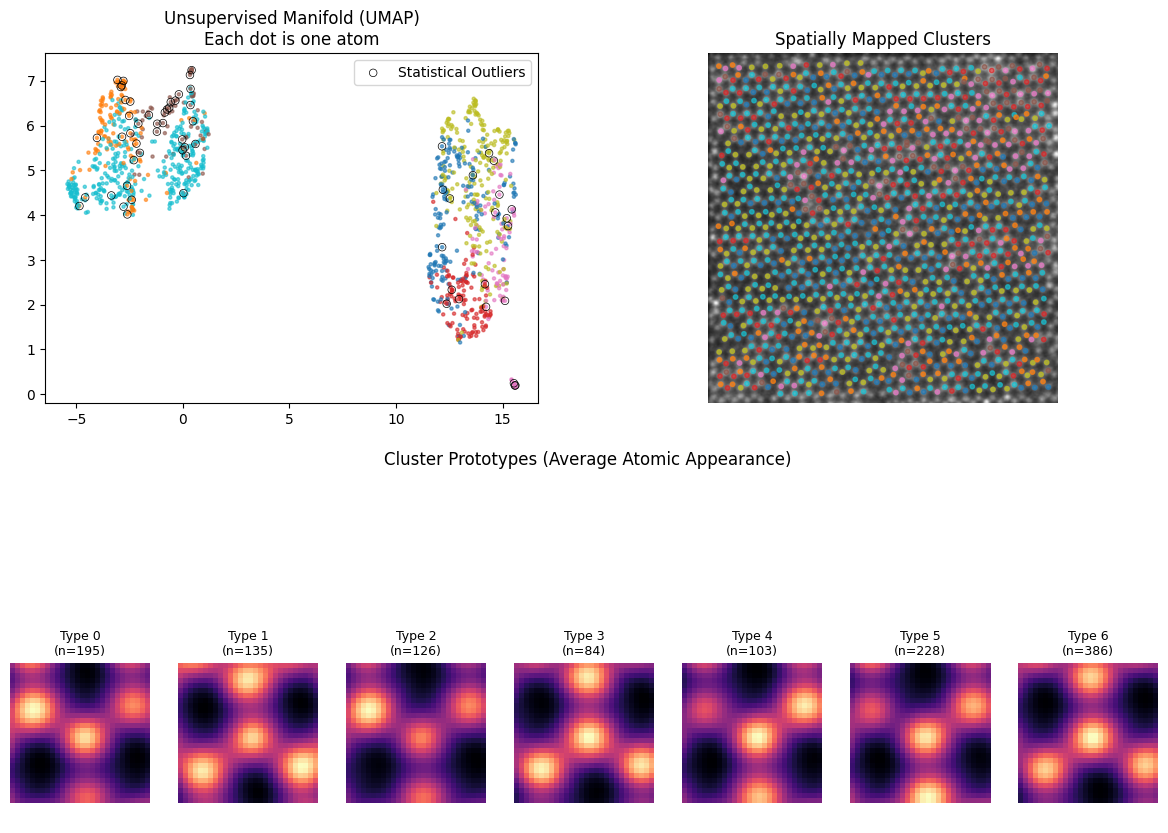

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import umap

def extract_atom_patches(image, coords, window_size=24):
    """
    Cuts a small square image patch centered on every atom.
    """
    patches = []
    valid_indices = []
    h, w = image.shape
    r = window_size // 2

    for i, (y, x) in enumerate(coords):
        y, x = int(y), int(x)
        # Check bounds
        if y-r >= 0 and y+r < h and x-r >= 0 and x+r < w:
            patch = image[y-r:y+r, x-r:x+r]
            patches.append(patch.flatten()) # Flatten to 1D vector
            valid_indices.append(i)

    return np.array(patches), np.array(valid_indices)

# --- 1. PREPARE DATA ---
# Use one of your test images (e.g., index 0)
test_idx = 1
img = X_test[test_idx].squeeze()
# Use the robust coordinates we found in the previous step (Predicted or GT)
# Let's assume 'pred_coords' contains [y, x, class] from the previous robust step
# We only care about (y,x) location, we will relearn the class unsupervised!
atom_locs = pred_coords[:, :2]

print(f"Extracting patches for {len(atom_locs)} atoms...")
patches, valid_idxs = extract_atom_patches(img, atom_locs, window_size=28)

# Normalize patches (Zero mean, Unit variance)
# This focuses the model on shape/structure rather than absolute brightness
scaler = StandardScaler()
patches_norm = scaler.fit_transform(patches)

# --- 2. DIMENSIONALITY REDUCTION ---
print("Running PCA...")
# Reduce from ~784 pixels to 32 components (removes noise)
pca = PCA(n_components=32, random_state=42)
pca_features = pca.fit_transform(patches_norm)

print("Running UMAP...")
# Reduce from 32 PCA comps to 2D for visualization
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(pca_features)

# --- 3. CLUSTERING (GMM) ---
# We assume there are ~5 main types (Mo, W, S2, SSe, Se2)
# + maybe 2 defect types = 7 clusters
n_clusters = 7
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
labels = gmm.fit_predict(pca_features)

# Calculate "Anomalousness"
# Samples with low probability density in the GMM are likely unique defects
log_prob = gmm.score_samples(pca_features)
# Bottom 5% likelihood are outliers
outlier_mask = log_prob < np.percentile(log_prob, 5)

# --- 4. VISUALIZATION ---
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2)

# Plot A: The Latent Space (The "Map of Atoms")
ax1 = fig.add_subplot(gs[0, 0])
scatter = ax1.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=5, alpha=0.6)
# Highlight outliers (Rare Defects)
ax1.scatter(embedding[outlier_mask, 0], embedding[outlier_mask, 1],
            s=30, facecolors='none', edgecolors='k', linewidth=0.5, label='Statistical Outliers')
ax1.set_title("Unsupervised Manifold (UMAP)\nEach dot is one atom")
ax1.legend()

# Plot B: Spatial Distribution (Where are they?)
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(img, cmap='gray')
ax2.scatter(atom_locs[valid_idxs, 1], atom_locs[valid_idxs, 0], c=labels, cmap='tab10', s=10, alpha=0.7)
ax2.set_title("Spatially Mapped Clusters")
ax2.axis('off')

# Plot C: The "Mean Atom" for each cluster
# This helps us identify what the cluster actually represents
ax3 = fig.add_subplot(gs[1, :])
ax3.axis('off')
ax3.set_title("Cluster Prototypes (Average Atomic Appearance)")

for k in range(n_clusters):
    # Get all patches belonging to this cluster
    cluster_patches = patches[labels == k]
    # Calculate mean image
    mean_patch = np.mean(cluster_patches, axis=0).reshape(28, 28)

    # Add subplot
    sub_ax = fig.add_axes([0.1 + k*0.12, 0.1, 0.1, 0.2]) # Manual positioning
    sub_ax.imshow(mean_patch, cmap='magma')
    sub_ax.set_title(f"Type {k}\n(n={len(cluster_patches)})", fontsize=9)
    sub_ax.axis('off')

plt.show()

Lattice Constant (Bond Length): 11.05 px
Found 1 vacancies.


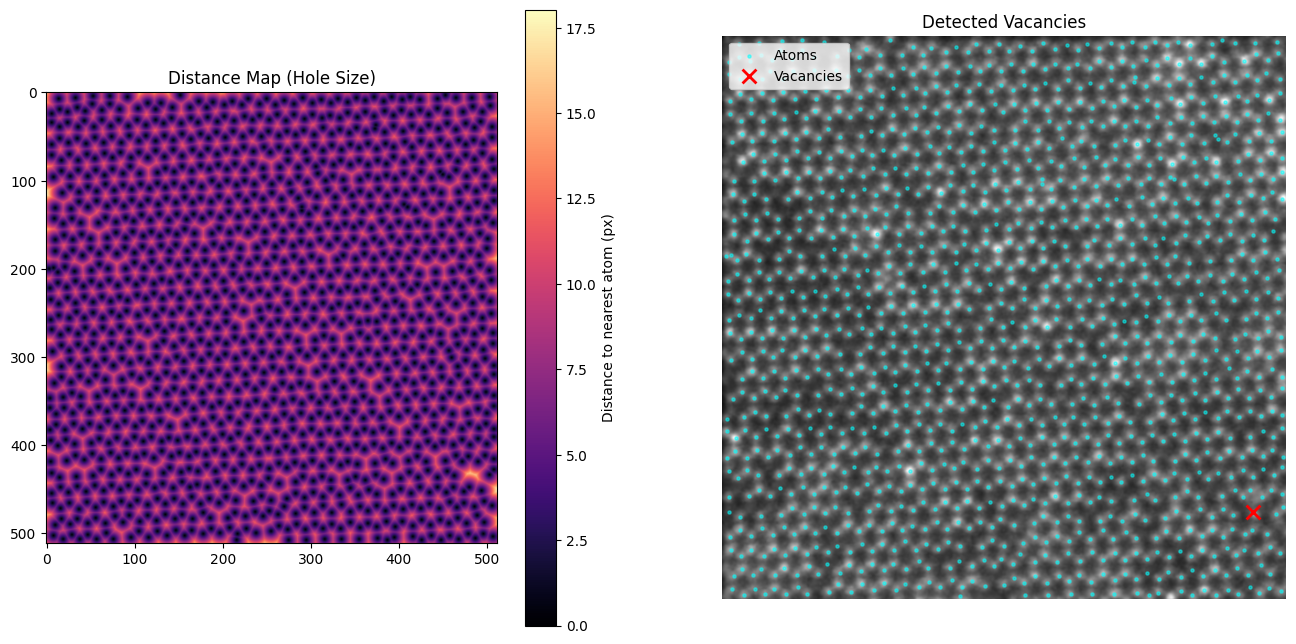

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max

def find_vacancies_robust(image_shape, atom_coords, lattice_const_px):
    """
    Finds vacancies by creating a Distance Map from every pixel to the nearest atom.
    True vacancies appear as 'peaks' in this map that are higher than the
    natural holes in the lattice.
    """
    # 1. Create a binary mask of atom positions
    mask = np.zeros(image_shape, dtype=bool)

    # Ensure coords are integers and within bounds
    # atom_coords is [y, x]
    coords_int = np.round(atom_coords).astype(int)

    # Clip to image boundaries
    h, w = image_shape
    coords_int[:, 0] = np.clip(coords_int[:, 0], 0, h-1)
    coords_int[:, 1] = np.clip(coords_int[:, 1], 0, w-1)

    mask[coords_int[:, 0], coords_int[:, 1]] = True

    # 2. Compute Euclidean Distance Transform (Inverted)
    # distance_transform_edt computes distance to nearest '0' (background)
    # So we invert mask: Atoms are 0 (target), Background is 1
    dist_map = distance_transform_edt(~mask)

    # 3. Define Threshold for "True Vacancy"
    # In a perfect honeycomb, the hole radius is approx 1.0 * lattice_const (center to atom)
    # A vacancy radius is approx 1.7-2.0 * lattice_const
    # We set a threshold slightly larger than the natural hole size
    # You may need to tune '1.2' based on your specific resolution
    vacancy_threshold = 1.2 * lattice_const_px

    # 4. Find Peaks (Centers of holes)
    # min_distance ensures we don't find multiple points for the same hole
    peaks = peak_local_max(dist_map, min_distance=int(lattice_const_px),
                           threshold_abs=vacancy_threshold)

    return peaks, dist_map

# --- EXECUTION ---

# 1. Estimate Lattice Constant (if not already known)
# (Distance to nearest neighbor)
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2).fit(atom_locs)
dists, _ = nbrs.kneighbors(atom_locs)
est_lattice_constant = np.median(dists[:, 1])
print(f"Lattice Constant (Bond Length): {est_lattice_constant:.2f} px")

# 2. Run Detection
# Use the shape of your original image (e.g., 512x512)
img_shape = (512, 512)
vacancies_edt, dist_map = find_vacancies_robust(img_shape, atom_locs, est_lattice_constant)

print(f"Found {len(vacancies_edt)} vacancies.")

# --- VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot A: The Distance Map (The "Topology")
# Dark = close to atom, Bright = far from atom (hole)
cax = ax1.imshow(dist_map, cmap='magma')
ax1.set_title("Distance Map (Hole Size)")
fig.colorbar(cax, ax=ax1, label="Distance to nearest atom (px)")

# Plot B: The Detections
ax2.imshow(img, cmap='gray')
ax2.scatter(atom_locs[:, 1], atom_locs[:, 0], c='cyan', s=5, alpha=0.5, label='Atoms')
if len(vacancies_edt) > 0:
    # peak_local_max returns (y, x)
    ax2.scatter(vacancies_edt[:, 1], vacancies_edt[:, 0], c='red', marker='x', s=100, linewidth=2, label='Vacancies')
ax2.set_title("Detected Vacancies")
ax2.legend()
ax2.axis('off')

plt.show()